# LCT 4


In [1]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import seaborn as sns
import statsmodels.api as sm
import scipy as sp
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
import statsmodels.stats.api as sms
import statsmodels.stats.proportion as ssp
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import classification_report
from statsmodels.stats.outliers_influence import variance_inflation_factor
import patsy
import warnings
warnings.filterwarnings("ignore")
import os
os.chdir(r"C:\Users\willi\OneDrive\Documents\Woolf Institute Data Analytics\Module 4 Advanced Predictive Modelling\04_ Live Class Data Sets")

In [68]:
# Import Data
hospdata = pd.read_csv("Hospital Readmissions.csv")
print("✅ Include All")
print(hospdata.describe(include='all'))
print(hospdata.head())

✅ Include All
                  id      age  time_in_hospital  n_lab_procedures  \
count   25000.000000    25000       25000.00000       25000.00000   
unique           NaN        6               NaN               NaN   
top              NaN  [70-80)               NaN               NaN   
freq             NaN     6837               NaN               NaN   
mean    12500.500000      NaN           4.45332          43.24076   
std      7217.022701      NaN           3.00147          19.81862   
min         1.000000      NaN           1.00000           1.00000   
25%      6250.750000      NaN           2.00000          31.00000   
50%     12500.500000      NaN           4.00000          44.00000   
75%     18750.250000      NaN           6.00000          57.00000   
max     25000.000000      NaN          14.00000         113.00000   

        n_procedures  n_medications  n_outpatient   n_inpatient   n_emergency  \
count   25000.000000   25000.000000  25000.000000  25000.000000  25000.00000

In [69]:
print(hospdata.describe())

                 id  time_in_hospital  n_lab_procedures  n_procedures  \
count  25000.000000       25000.00000       25000.00000  25000.000000   
mean   12500.500000           4.45332          43.24076      1.352360   
std     7217.022701           3.00147          19.81862      1.715179   
min        1.000000           1.00000           1.00000      0.000000   
25%     6250.750000           2.00000          31.00000      0.000000   
50%    12500.500000           4.00000          44.00000      1.000000   
75%    18750.250000           6.00000          57.00000      2.000000   
max    25000.000000          14.00000         113.00000      6.000000   

       n_medications  n_outpatient   n_inpatient   n_emergency  
count   25000.000000  25000.000000  25000.000000  25000.000000  
mean       16.252400      0.366400      0.615960      0.186600  
std         8.060532      1.195478      1.177951      0.885873  
min         1.000000      0.000000      0.000000      0.000000  
25%        11.000

In [70]:
print(hospdata.shape)

(25000, 15)


In [71]:
hospdata["readmitted"]=hospdata["readmitted"].apply(lambda x: 0 if x == "no" else 1)

In [6]:
hospdata.head()

,id,age,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency,diagnosis,glucose_test,A1Ctest,change,diabetes_med,readmitted
0,1,[70-80),8,72,1,18,2,0,0,Circulatory,no,no,no,yes,0
1,2,[70-80),3,34,2,13,0,0,0,Other,no,no,no,yes,0
2,3,[50-60),5,45,0,18,0,0,0,Circulatory,no,no,yes,yes,1
3,4,[70-80),2,36,0,12,1,0,0,Circulatory,no,no,yes,yes,1
4,5,[60-70),1,42,0,7,0,0,0,Other,no,no,no,yes,0


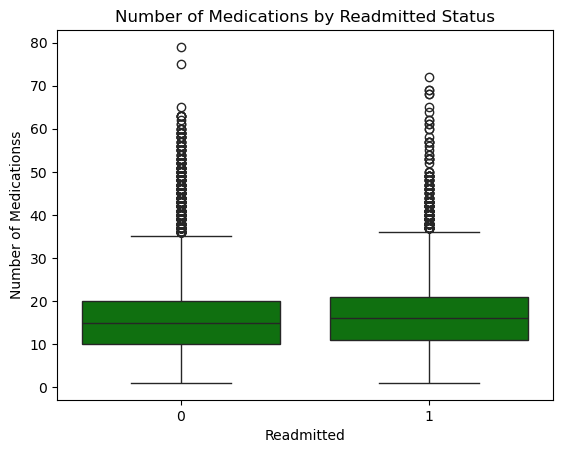

In [72]:
# Visualize the number of lab procedures by readmitted status
sns.boxplot(x='readmitted', y='n_medications', data=hospdata,color='green')

# Add labels and title for clarity
plt.xlabel('Readmitted')
plt.ylabel('Number of Medicationss')
plt.title('Number of Medications by Readmitted Status')


# Show the plot
plt.show()

In [73]:
grouped_data = hospdata.groupby(['age', 'readmitted']).size().reset_index(name='count')

# Calculate percentage within each age group
grouped_data['percent'] = grouped_data['count'] / grouped_data.groupby('age')['count'].transform('sum') * 100

In [74]:
print(grouped_data)

         age  readmitted  count    percent
0    [40-50)           0   1405  55.489731
1    [40-50)           1   1127  44.510269
2    [50-60)           0   2486  55.840072
3    [50-60)           1   1966  44.159928
4    [60-70)           0   3143  53.154067
5    [60-70)           1   2770  46.845933
6    [70-80)           0   3501  51.206670
7    [70-80)           1   3336  48.793330
8    [80-90)           0   2277  50.420726
9    [80-90)           1   2239  49.579274
10  [90-100)           0    434  57.866667
11  [90-100)           1    316  42.133333


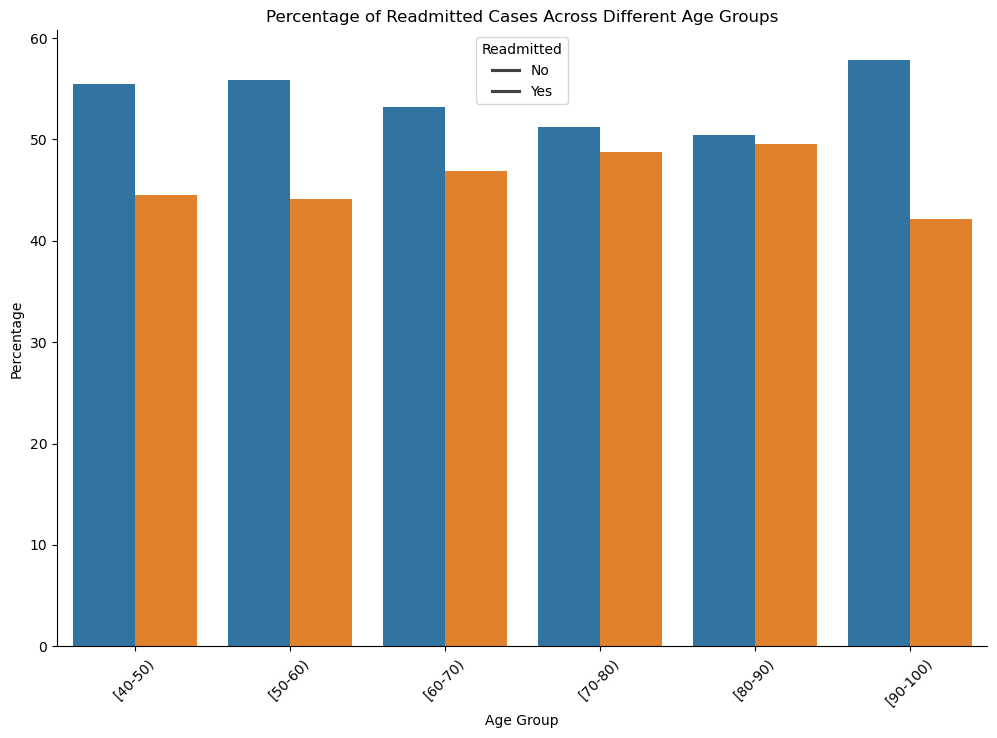

In [75]:
# Plot the data
plt.figure(figsize=(12, 8))
sns.barplot(x='age', y='percent', hue='readmitted', data=grouped_data)

# Add labels and title for clarity
plt.xlabel('Age Group')
plt.ylabel('Percentage')
plt.title('Percentage of Readmitted Cases Across Different Age Groups')
plt.xticks(rotation=45)  # Rotate x-axis labels if needed for better readability
plt.legend(title='Readmitted', labels=['No', 'Yes'])

# Show the plot
sns.despine()
plt.grid(False)

plt.show()

In [76]:
# Convert categorical variables to dummy variables
# Recode dependent variable
hospdata['readmitted'] = hospdata['readmitted'].apply(lambda x: 0 if x == "no" else 1)

# Check for missing values and handle them (e.g., drop or impute)
hospdata = hospdata.dropna()

# Convert categorical variables to dummy variables
categorical_vars = ['diagnosis', 'glucose_test', 'A1Ctest', 'change', 'diabetes_med']
hospdata = pd.get_dummies(hospdata, columns=categorical_vars, drop_first=True)
hospdata

,id,age,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency,readmitted,...,diagnosis_Missing,diagnosis_Musculoskeletal,diagnosis_Other,diagnosis_Respiratory,glucose_test_no,glucose_test_normal,A1Ctest_no,A1Ctest_normal,change_yes,diabetes_med_yes
0,1,[70-80),8,72,1,18,2,0,0,1,...,False,False,False,False,True,False,True,False,False,True
1,2,[70-80),3,34,2,13,0,0,0,1,...,False,False,True,False,True,False,True,False,False,True
2,3,[50-60),5,45,0,18,0,0,0,1,...,False,False,False,False,True,False,True,False,True,True
3,4,[70-80),2,36,0,12,1,0,0,1,...,False,False,False,False,True,False,True,False,True,True
4,5,[60-70),1,42,0,7,0,0,0,1,...,False,False,True,False,True,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,24996,[80-90),14,77,1,30,0,0,0,1,...,False,False,False,False,True,False,False,True,False,False
24996,24997,[80-90),2,66,0,24,0,0,0,1,...,False,False,False,False,True,False,False,False,True,True
24997,24998,[70-80),5,12,0,6,0,1,0,1,...,False,False,True,False,False,True,True,False,False,False
24998,24999,[70-80),2,61,3,15,0,0,0,1,...,False,False,False,True,True,False,True,False,True,True


In [77]:
# check dimensions
print(hospdata.shape)

(25000, 23)


In [78]:
# Ensure all data types are numerical
for column in hospdata.columns:
    if hospdata[column].dtype == object:
        hospdata[column] = hospdata[column].astype('category').cat.codes

# Split the data into training and testing datasets
train_data, test_data = train_test_split(hospdata, test_size=0.3, random_state=42, stratify=hospdata ['readmitted'])

# Define the independent variables
independent_vars = [col for col in hospdata.columns if col != 'readmitted']

print("Independent Variables:")
print(independent_vars)

Independent Variables:
['id', 'age', 'time_in_hospital', 'n_lab_procedures', 'n_procedures', 'n_medications', 'n_outpatient', 'n_inpatient', 'n_emergency', 'diagnosis_Diabetes', 'diagnosis_Digestive', 'diagnosis_Injury', 'diagnosis_Missing', 'diagnosis_Musculoskeletal', 'diagnosis_Other', 'diagnosis_Respiratory', 'glucose_test_no', 'glucose_test_normal', 'A1Ctest_no', 'A1Ctest_normal', 'change_yes', 'diabetes_med_yes']


In [79]:
X_train = X_train.apply(pd.to_numeric, errors='raise')
y_train = pd.to_numeric(y_train, errors='raise')

In [58]:
# Add a constant to the independent variables (for the intercept term)
X_train = sm.add_constant(train_data[independent_vars])
X_test = sm.add_constant(test_data[independent_vars])
# Define the dependent variable
y_train = train_data['readmitted']
y_test = test_data['readmitted']
# Build the logistic regression model
model = sm.Logit(y_train.astype(float), X_train.astype(float)).fit()

# Summarize the model
print("Model Summary:")
print(model.summary())

         Current function value: 0.000000
         Iterations: 35
Model Summary:
                           Logit Regression Results                           
Dep. Variable:             readmitted   No. Observations:                17500
Model:                          Logit   Df Residuals:                    17477
Method:                           MLE   Df Model:                           22
Date:                Sat, 17 May 2025   Pseudo R-squ.:                     inf
Time:                        10:56:50   Log-Likelihood:            -0.00032402
converged:                      False   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        33.7239   1630.683      0.021      0.984   -3162.356    3229.804
id   

In [80]:
from sklearn.metrics import confusion_matrix, classification_report
X_test = sm.add_constant(test_data[independent_vars])

# Predict probabilities on the test data

test_data['predprob'] = model.predict(X_test.astype(int))

# Define a threshold
threshold = 0.5

# Classify based on the threshold
test_data['predY'] = (test_data['predprob'] > threshold).astype(int)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, test_data['predY'])
print("Confusion Matrix:")
print(conf_matrix)

# Print classification report for additional metrics
print("\nClassification Report:")
print(classification_report(y_test, test_data['predY']))

Confusion Matrix:
[[7500]]

Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      7500

    accuracy                           1.00      7500
   macro avg       1.00      1.00      1.00      7500
weighted avg       1.00      1.00      1.00      7500



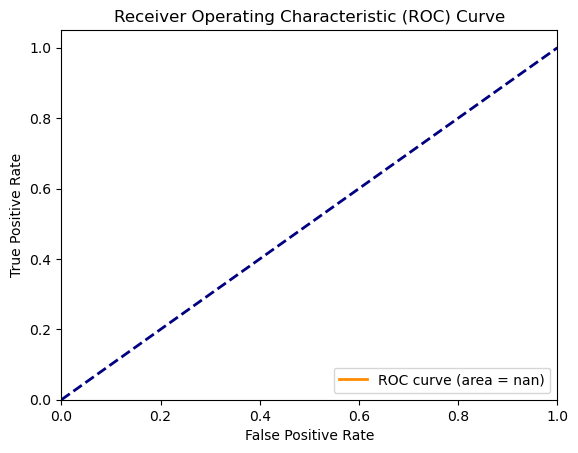

AUC: nan


In [81]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, test_data['predprob'])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Print AUC
print(f"AUC: {roc_auc:.2f}")

In [45]:
print("Unique predicted probabilities:", test_data['predprob'].nunique())


Unique predicted probabilities: 5954


In [46]:
print("Class counts in y_test:", y_test.value_counts())


Class counts in y_test: readmitted
1    7500
Name: count, dtype: int64


In [47]:
print("NaN in y_test:", y_test.isna().sum())
print("NaN in predprob:", test_data['predprob'].isna().sum())

NaN in y_test: 0
NaN in predprob: 0


In [48]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Check for NaN/constant values
print("Class distribution in y_test:\n", y_test.value_counts())
print("Unique predicted probabilities:", test_data['predprob'].nunique())
print("NaN in y_test:", y_test.isna().sum())
print("NaN in predprob:", test_data['predprob'].isna().sum())

# Drop NaN values if any (critical!)
y_test_clean = y_test.dropna()
predprob_clean = test_data['predprob'].loc[y_test_clean.index]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test_clean, predprob_clean)
roc_auc = auc(fpr, tpr)

# Plot only if AUC is valid
if not np.isnan(roc_auc):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    print(f"AUC: {roc_auc:.2f}")
else:
    print("Warning: AUC is NaN. Check for constant predictions or single-class labels.")

Class distribution in y_test:
 readmitted
1    7500
Name: count, dtype: int64
Unique predicted probabilities: 5954
NaN in y_test: 0
NaN in predprob: 0


In [49]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

NameError: name 'X' is not defined